# Manufacturing Processes HW: Widget Production
_Author: Simone Cherry-Delisle_

In [1]:
!pip install -q pymannkendall
!pip install -q rpy2

import numpy as np
import pandas as pd
import pymannkendall as mk
from scipy.stats import chi2_contingency

%load_ext rpy2.ipython

In [2]:
%%R
invisible(install.packages("qcc"))
library(qcc)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cran.rstudio.com/src/contrib/qcc_2.7.tar.gz'
Content type 'application/x-gzip' length 3307174 bytes (3.2 MB)
downloaded 3.2 MB


The downloaded source packages are in
	‘/tmp/RtmpPGjmTY/downloaded_packages’
  __ _  ___ ___ 
 / _  |/ __/ __|  Quality Control Charts and 
| (_| | (_| (__   Statistical Process Control
 \__  |\___\___|
    |_|           version 2.7
Type 'citation("qcc")' for citing this R package in publications.


Assume that the occurrence of defective widgets $X$ may be described as an i.i.d. sequence of Bernoulli trials, each with probability $0.03$ of defect; that is, $X\ \sim Bin\left(\ n,\ p=0.03\ \right)$. Addionally, assume that the sampling rate is $200$ widgets per hour and that the production rate is $1000$ widgets per hour.

(*Note: Here, I modified the sample rate from $50$ widgets per hour to eliminate the problem of observing fractional defect counts.*)

# Question on Trend Analysis:
Over three consecutive hours, the defect rates observed are 2%, 3.5%, and 1.5%. Analyze the trend and propose potential reasons for variations.

# Solution

For hour $i\in \{1,2,3\}$, let $\hat{p}_{i}$ be the sample proportion of defects over $i$, $n_i$ be the number of samples over $i$, and $x_i$ be the number of defects over $i$. But $\hat{p}_{1}=0.02$, $\hat{p}_{2}=0.035$, $\hat{p}_{3}=0.015$, and $n_1 = n_2 = n_3 = 200$, from which it follows that the number of defects are $x_{1}=4$, $x_{2}=7$, and $x_{3}=3$ and the number of non-defects are $n_{1} - x_{1}=196$, $n_{2} - x_{2}=193$, and $n_{3} - x_{3}=197$.



In [3]:
data = {
    'Hr 1':[4, 196],
    'Hr 2':[7, 193],
    'Hr 3':[3, 197],
}

df1 = pd.DataFrame(data, index=['defective', 'non_defective'])
print(df1)

               Hr 1  Hr 2  Hr 3
defective         4     7     3
non_defective   196   193   197


## $\chi^{2}$ Test for Homogeneity

Using the $\chi^{2}$ test for homogeneity, we test the null hypothesis of equality of defect proportions

$$ H_{0} : p_{1} = p_{2} \text{ and } p_{2} = p_{3} \text{ and } p_{1} = p_{3}$$

against the alternative hypothesis of inequality

$$ H_{A} : p_{1} \neq p_{2} \text{ or } p_{2} \neq p_{3} \text{ or } p_{1} \neq p_{3}$$

at the $\alpha = 0.05$ level of significance.  

In [4]:
chi2, p_val, dof, expected = chi2_contingency(df1)

print(f"\nChi-squared statistic: {chi2:.4f}")
print(f"Degrees of freedom: {dof}")
print(f"P-value: {p_val:.4f}")

expected_df1 = pd.DataFrame(expected, index=df1.index, columns=df1.columns)
print("\nExpected Frequencies:")
print(expected_df1)


Chi-squared statistic: 1.9015
Degrees of freedom: 2
P-value: 0.3864

Expected Frequencies:
                     Hr 1        Hr 2        Hr 3
defective        4.666667    4.666667    4.666667
non_defective  195.333333  195.333333  195.333333


As the p-value is greater than $0.05$, we fail to reject the null hypothesis of equality of defect proportions

$$ H_{0} : p_{1} = p_{2} \text{ and } p_{2} = p_{3} \text{ and } p_{1} = p_{3}$$

at the $\alpha = 0.05$ level of significance.  

## Mann-Kendall Test

We apply the double-sided Mann-Kendall test for monotonic trend in defect proportions under the assumption that the series of defect proportions is not serially autocorrelated. We test the null hypothesis of no monotonic trend

$$ H_{0} : p_{1}, p_{2}, p_{3} \text{ are i.i.d.}$$

against the alternative hypothesis

$$ H_{A} : \text{There exists a monotonic trend (either increasing or decreasing)}$$

at the $\alpha = 0.05$ level of significance.  



In [5]:
df2 = df1.T
df2["total_samples"] = df2["defective"] + df2["non_defective"]
df2["proportion_defective"] = df2["defective"] / (df2["total_samples"])
print(df2)

      defective  non_defective  total_samples  proportion_defective
Hr 1          4            196            200                 0.020
Hr 2          7            193            200                 0.035
Hr 3          3            197            200                 0.015


In [6]:
result = mk.original_test(df2["proportion_defective"], alpha=0.05)
print(f"P-value: {result.p:.4f}")

P-value: 1.0000


As the p-value is greater than $0.05$, we fail to reject the null hypothesis

$$ H_{0} : p_{1}, p_{2}, p_{3} \text{ are i.i.d.}$$

at the $\alpha = 0.05$ level of significance.  

## p-Chart

We plot a Shewart proportion chart to monitor the proportions of defective samples $\hat{p}_{i}$ over the hours $i\in \{1,2,3\}$ under the control limits

$$ \bar{p} \pm 3\sqrt{\frac{\bar{p}\left(1-\bar{p}\right)}{n}}.$$

In [7]:
%R -i df2

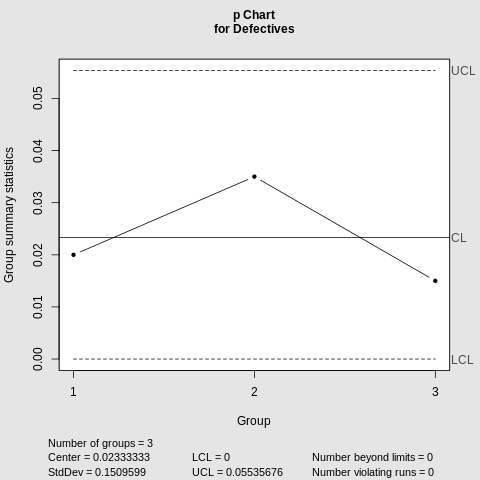

In [8]:
%%R

Defectives <- df2$defective
Samples <- df2$total_samples

p_chart <- qcc(Defectives, sizes = Samples, type = "p")

Because the proportions of defective samples $\hat{p}_{i}$ fall within the control limits, the p-chart suggests that the process is in control.

## Conclusion

The results of the $\chi^{2}$ test for homogeneity, the Mann-Kendall test for monotonicity, as well as the Shewart p-chart suggest that the proportion of defective widgets observed remains stable over the interval the process was observed. Further sampling may be needed to confirm the stability of this process.